In [43]:
import numpy as np
import cv2

data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [44]:
import torch
from torch.autograd import Variable

In [45]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # One in and one out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
# our model
our_model = Perceptron()
 
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
 
for epoch in range(1000):
 
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = our_model(x_data)
 
    # Compute and print loss
    loss = criterion(pred_y, y_data)
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))
 


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0, loss 640.4166870117188
epoch 1, loss 162.838134765625
epoch 2, loss 152.86012268066406
epoch 3, loss 149.762939453125
epoch 4, loss 143.84400939941406
epoch 5, loss 143.60081481933594
epoch 6, loss 137.03005981445312
epoch 7, loss 139.57177734375
epoch 8, loss 131.2156982421875
epoch 9, loss 132.75027465820312
epoch 10, loss 124.14271545410156
epoch 11, loss 128.47854614257812
epoch 12, loss 122.43421936035156
epoch 13, loss 125.7839126586914
epoch 14, loss 112.7886962890625
epoch 15, loss 116.8636474609375
epoch 16, loss 111.93080139160156
epoch 17, loss 115.55714416503906
epoch 18, loss 103.86546325683594
epoch 19, loss 108.41236877441406
epoch 20, loss 100.97512817382812
epoch 21, loss 103.8537826538086
epoch 22, loss 95.12493896484375
epoch 23, loss 99.72626495361328
epoch 24, loss 90.36016082763672
epoch 25, loss 92.34364318847656
epoch 26, loss 85.15373992919922
epoch 27, loss 87.76446533203125
epoch 28, loss 80.005615234375
epoch 29, loss 81.4530029296875
epoch 30, loss

epoch 354, loss 3.405679941177368
epoch 355, loss 3.394861936569214
epoch 356, loss 3.38411021232605
epoch 357, loss 3.373422861099243
epoch 358, loss 3.3628005981445312
epoch 359, loss 3.352241277694702
epoch 360, loss 3.3417468070983887
epoch 361, loss 3.331315040588379
epoch 362, loss 3.3209447860717773
epoch 363, loss 3.3106367588043213
epoch 364, loss 3.3003909587860107
epoch 365, loss 3.2902047634124756
epoch 366, loss 3.280078887939453
epoch 367, loss 3.2700135707855225
epoch 368, loss 3.2600066661834717
epoch 369, loss 3.25005841255188
epoch 370, loss 3.240169048309326
epoch 371, loss 3.230337142944336
epoch 372, loss 3.2205617427825928
epoch 373, loss 3.210844039916992
epoch 374, loss 3.201181411743164
epoch 375, loss 3.191575288772583
epoch 376, loss 3.1820244789123535
epoch 377, loss 3.1725285053253174
epoch 378, loss 3.1630866527557373
epoch 379, loss 3.1536991596221924
epoch 380, loss 3.144364356994629
epoch 381, loss 3.1350834369659424
epoch 382, loss 3.1258537769317627
e

epoch 751, loss 1.476452112197876
epoch 752, loss 1.4743026494979858
epoch 753, loss 1.4721596240997314
epoch 754, loss 1.4700227975845337
epoch 755, loss 1.467891812324524
epoch 756, loss 1.4657670259475708
epoch 757, loss 1.4636478424072266
epoch 758, loss 1.4615349769592285
epoch 759, loss 1.459427833557129
epoch 760, loss 1.457327127456665
epoch 761, loss 1.4552314281463623
epoch 762, loss 1.4531422853469849
epoch 763, loss 1.4510588645935059
epoch 764, loss 1.4489808082580566
epoch 765, loss 1.4469091892242432
epoch 766, loss 1.444843053817749
epoch 767, loss 1.4427825212478638
epoch 768, loss 1.4407278299331665
epoch 769, loss 1.4386789798736572
epoch 770, loss 1.4366353750228882
epoch 771, loss 1.4345979690551758
epoch 772, loss 1.4325659275054932
epoch 773, loss 1.4305393695831299
epoch 774, loss 1.4285186529159546
epoch 775, loss 1.4265035390853882
epoch 776, loss 1.424493670463562
epoch 777, loss 1.4224891662597656
epoch 778, loss 1.4204906225204468
epoch 779, loss 1.41849720

In [10]:
p = our_model(Variable(torch.Tensor([data[9]]))).cpu().detach().numpy()
p = p.reshape(16, 16)
p[p <= 0.5] = 0
p[p > 0.5] = 1
p

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,

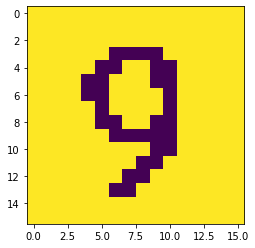

In [11]:
import matplotlib.pyplot as plt
plt.imshow(p)

In [50]:
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        data_sample = Variable(torch.Tensor([data[i]])).numpy()
        data_sample = data_sample.reshape(16, 16)
        input_data.append(data_sample)
        
    return input_data

In [51]:
def generate_predictions(data):
    predicted_output = []
    
    for i in range(10):
        p = our_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [91]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [106]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [107]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    for i, sample in enumerate(data2):
        for j,d in enumerate(sample):
            if d == 0:
                if data1[i][j] == 0:
                    match_ctr +=1
    return match_ctr

In [108]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    for i, sample in enumerate(data2):
        for j,d in enumerate(sample):
            if d == 0:
                if not data1[i][j] == 0:
                    mismatch_ctr +=1
    return mismatch_ctr

In [112]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        print("Fraction of hits is {}".format(fh_ratio))
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        print("Fraction of false alarms is {}".format(ffa_ratio))
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [113]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data)

In [114]:
fh, ffa = compute_error_metrics(input_data, predicted_output)

Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
